In [2]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import pandas as pd
import os
from mpl_toolkits import mplot3d
from scipy.linalg import lstsq
import math

## Backtracking Kv from TDLAS Data (F2 HH Cycle)

Note: This was the cycle we had missing data around the time where the primary drying was ending. I just set everything as a constant from the last value it recorded.

In [19]:
#Load Data
#Initial Data
file_location1 = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\TDLAS Data\F4_HH.xlsx'
assert os.path.isfile(file_location1)
df1 = pd.read_excel(file_location1,sheet_name='Sheet1')
print(list(df1.columns))

#Initial Data(SV File)
file_location2 = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\220711_GS-0132_F2_0C125mT_SV.xlsx'
assert os.path.isfile(file_location2)
df2 = pd.read_excel(file_location2,sheet_name='220711_GS-0132_F2_0C125mT_SV')
print(list(df2.columns))

# Load Data(PP File)
file_location3 = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\220711_GS-0132_F2_0C125mT_PP.xlsx'
assert os.path.isfile(file_location3)
df3 = pd.read_excel(file_location3,sheet_name='220711_GS-0132_F2_0C125mT_PP')
print("Headers:")
print(list(df3.columns))

['Date/Time', 'Delta Time from filestart', 'Process [H2O]', 'Refcell [H2O]', 'Velocity', 'Mass Flow', 'Mass Flow Scaling', 'Process Purge', 'RefCell Purge', 'Pressure', 'Process Temp', 'RefCell Temp', 'Shelf Temp', 'Error Code', 'Unnamed: 14', 'per data point', 'per data point.1', 'Removal']
['Timestamp', ' SPLYO.CONDENSER_TEMPERATURE.F_CV', ' SPLYO.SHELF_OUTLET.F_CV', ' SPLYO.SHELF_INLET.F_CV', ' SPLYO.SHELF_SP.F_CV', ' SPLYO.TC_AVG.F_CV', ' SPLYO.VACUUM_SP.F_CV', ' SPLYO.CHAMBER_CM.F_CV', ' SPLYO.ROUGH_VACUUM.F_CV', ' SPLYO.CHAMBER_PIRANI.F_CV', ' SPLYO.CONDENSER_VACUUM.F_CV']
Headers:
['Timestamp', ' SPLYO.TC01.F_CV', ' SPLYO.TC02.F_CV', ' SPLYO.TC03.F_CV', ' SPLYO.TC04.F_CV', ' SPLYO.TC05.F_CV', ' SPLYO.TC06.F_CV', ' SPLYO.TC07.F_CV', ' SPLYO.TC08.F_CV', ' SPLYO.TC09.F_CV', ' SPLYO.TC10.F_CV', ' SPLYO.TC11.F_CV', ' SPLYO.TC12.F_CV', ' SPLYO.TC13.F_CV', ' SPLYO.TC14.F_CV', ' SPLYO.TC15.F_CV', ' SPLYO.TC16.F_CV', ' SPLYO.TC_AVG.F_CV']


##### Note: TDLAS data is every minute but the lyo data is every 5 mins, so have to adjust the sampling from TDLAS to back calculate the Kv.

In [20]:
#Define needed parameters/inputs
SAout=7.0685775
vial_number=86 #number of filled vials used
T_shelf= ((df2[[' SPLYO.SHELF_SP.F_CV']]).values).reshape(-1)
T_p_2NN=((df3[[' SPLYO.TC06.F_CV']]).values).reshape(-1)
T_p_3NN=((df3[[' SPLYO.TC03.F_CV']]).values).reshape(-1)
T_p_4NN=((df3[[' SPLYO.TC01.F_CV']]).values).reshape(-1)

print(T_shelf.shape)
print(T_p_2NN.shape)
print(T_shelf)
print(T_p_2NN)

(1440,)
(1440,)
[ 0.  0.  0. ... 20. 20. 20.]
[15.7 15.7 15.8 ...  6.8  6.8  6.8]


In [26]:
#Extract sublimation rate (g/s)

#Need to extract data every five minutes only
mf=(df1[['Mass Flow']]).values
mf=mf.reshape(-1)

#Elapsed Time Array
time=(df2[['Timestamp']]).values #every 5 mins
ind=(np.arange(0,len(time)*5,5)) #Create array for time passed in increments of 5 mins

#Find index of ind array where the mf.shape value exists
w=np.where(ind==mf.shape[0])
w=np.asarray(w)

#Truncate the ind array only up to that index
ind=ind[0:w[0,0]]
#Extract elements of mf using the ind array
mf_new=mf[ind]

#Convert mass flow to (g/s/vial)
sub_rate=mf_new/vial_number

#Calculate Heat Flow
hf=sub_rate*676/SAout

#Truncate Tshelf and Tp based on mf shape
T_shelf_new=T_shelf[0:mf_new.shape[0]]
T_p_2NN_new=T_p_2NN[0:mf_new.shape[0]]
T_p_3NN_new=T_p_3NN[0:mf_new.shape[0]]
T_p_4NN_new=T_p_4NN[0:mf_new.shape[0]]

#Find Kv based on Heat Flow
kv_2_old=hf/(T_shelf_new-T_p_2NN_new)
kv_3_old=hf/(T_shelf_new-T_p_3NN_new)
kv_4_old=hf/(T_shelf_new-T_p_4NN_new)
print(kv_2_old.shape)
print(kv_3_old.shape)
print(kv_4_old.shape)
#Remove any infinite values due to divide by zero
for i in range(kv_2_old.shape[0]):
    if kv_2_old[i]==float('+inf'):
        kv_2=np.delete(kv_2_old, i)
    if kv_3_old[i]==float('+inf'):
        kv_3=np.delete(kv_3_old,i)
    if kv_4_old[i]==float('+inf'):
        kv_4=np.delete(kv_4_old,i)
#Change the dtype to float64 to avoid precision issues
kv_2=kv_2.astype("float64")
kv_3=kv_3.astype("float64")
kv_4=kv_4.astype("float64")
print(kv_2.shape)
print(kv_3.shape)
print(kv_4.shape)

(1064,)
(1064,)
(1064,)
(1063,)
(1063,)
(1063,)


<ipython-input-26-2ef26f447567>:33: RuntimeWarning: divide by zero encountered in true_divide
  kv_2_old=hf/(T_shelf_new-T_p_2NN_new)
<ipython-input-26-2ef26f447567>:34: RuntimeWarning: divide by zero encountered in true_divide
  kv_3_old=hf/(T_shelf_new-T_p_3NN_new)
<ipython-input-26-2ef26f447567>:35: RuntimeWarning: divide by zero encountered in true_divide
  kv_4_old=hf/(T_shelf_new-T_p_4NN_new)


[-0.00000000e+00 -2.56963759e-06 -2.40831758e-06 ...  1.79963404e-06
  1.79230476e-06  1.82355952e-06]
[-0.00000000e+00 -2.56963759e-06 -2.42365718e-06 ...  1.74670363e-06
  1.73958991e-06  1.76992542e-06]
[-0.00000000e+00 -2.74444286e-06 -2.57104174e-06 ...  1.63828754e-06
  1.63161537e-06  1.66006798e-06]


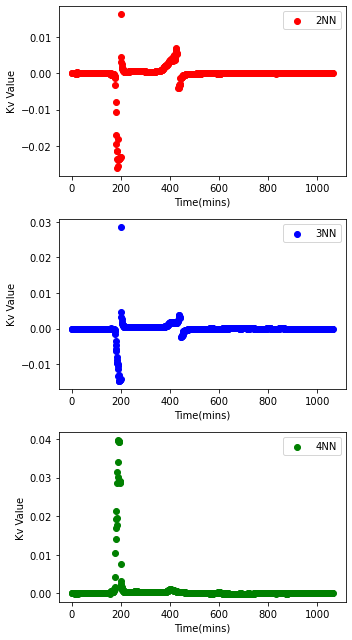

In [27]:
#Output
print(kv_2)
print(kv_3)
print(kv_4)

#Plot
plt.figure(figsize=(5, 9))
plt.subplot(3,1,1)
plt.scatter(np.arange(0,kv_2.shape[0],1),kv_2,color="red",label="2NN")
plt.xlabel("Time(mins)")
plt.ylabel("Kv Value")
plt.legend()
plt.subplot(3,1,2)
plt.scatter(np.arange(0,kv_3.shape[0],1),kv_3,color="blue",label="3NN")
plt.xlabel("Time(mins)")
plt.ylabel("Kv Value")
plt.legend()
plt.subplot(3,1,3)
plt.scatter(np.arange(0,kv_4.shape[0],1),kv_4,color="green",label="4NN")
plt.xlabel("Time(mins)")
plt.ylabel("Kv Value")
plt.legend()
plt.tight_layout()

In [23]:
def sse(x1,x2):
    sse=[]
    for i in range(len(x1)):
        sse.append(math.pow(x1[i]-x2[i],2))
    sse=np.array(sse)
    return np.sum(sse)

In [29]:
# print("SSE for Kv2 vs Kv3:",sse(kv_2,kv_3))
# print("SSE for Kv3 vs Kv4:",sse(kv_3,kv_4))
# print("SSE for Kv2 vs Kv4:",sse(kv_2,kv_4))

### Note: Warning indicates that the difference is too small for python to store so it outputs a nan. This means no significant different is found between Kv values based on vial nearest neighbour configuration.

Number of Outliers for 2NN : 374
(689,)
Number of Negative Values for 2NN : 282
(407,)
Number of Outliers for 3NN : 371
(692,)
Number of Negative Values for 3NN : 285
(407,)
Number of Outliers for 4NN : 58
(1005,)
Number of Negative Values for 4NN : 387
(618,)
Avg Kv for 2NN : 0.0012553412713576222
Avg Kv for 3NN : 0.0012553412713576222
Avg Kv for 4NN : inf


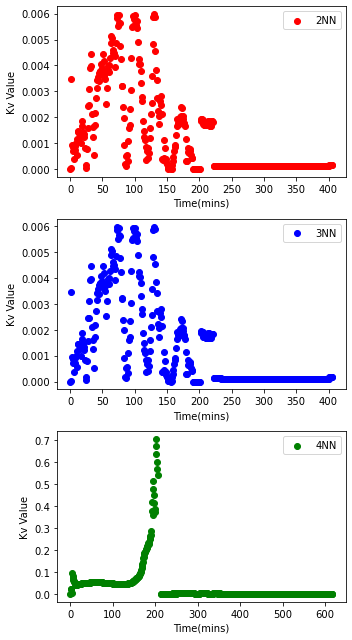

In [35]:
# Take Average Kv Values without outlier points and negative points
kv=np.array([kv_2,kv_3,kv_4])
avg=np.zeros(3)
x=["2NN","3NN","4NN"]
color=["red","blue","green"]

plt.figure(figsize=(5,9))
for i in range(3):
    # IQR
    kv
    Q1 = np.percentile(kv[i], 25,
                       interpolation = 'midpoint')
    Q3 = np.percentile(kv[i], 75,
                       interpolation = 'midpoint')
    IQR = Q3 - Q1

    # Above Upper bound
    upper = kv[i,:] >= (Q3+1.5*IQR)
    drop=(np.where(upper))[0]

    # Below Lower bound
    lower = kv[i,:] <= (Q1-1.5*IQR)
    drop=np.append(drop,np.where(lower)[0])
    print("Number of Outliers for",x[i],":",drop.shape[0])
    
    #Drop Outliers
    kv_out=np.delete(kv_2,drop)
    print(kv_out.shape)
    
    #Drop Negative Values
    ind=[]
    for j in range(len(kv_out)):
        if kv_out[j]<0:
            ind.append(j)
    print("Number of Negative Values for",x[i],":",len(ind))
    kv_out=np.delete(kv_out,ind)
    print(kv_out.shape)
    
    #Find Average and Store
    avg[i]=np.mean(kv_out*100)
    
    #Plot
    plt.subplot(3, 1, i+1)
    plt.scatter(np.arange(0,kv_out.shape[0],1),kv_out*100,color=color[i],label=x[i])
    plt.xlabel("Time(mins)")
    plt.ylabel("Kv Value")
    plt.legend()
    plt.tight_layout()
for i in range(3):
    print("Avg Kv for",x[i],":",avg[i])

Ask about the magnitude factor(100). When I used this value it fitted way better than the value from the hyperplane fitting.